In [1]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
# warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium
import seaborn as sns

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, os.path.join('src'))

from split_images import split_geometry
import feature_extraction as fe

In [3]:
ee.Authenticate()
ee.Initialize()

In [4]:
'''
We begin by preparing some constant variables that will be used throughout the notebook. 
Note that a seed is set for reproducibility.
'''

SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B2', 'B3', 'B4']

In [5]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [6]:
dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2020-01-01', '2021-01-30')
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))
    .map(mask_s2_clouds)
)

In [7]:
# geometry_sd = ee.Geometry.Polygon(
#     [[[-70.08239177868184,18.412691062890588],
#       [-69.70542339489278,18.412691062890588],
#       [-69.70542339489278,18.610630760258402],
#       [-70.08239177868184,18.610630760258402]]])

geometry_sd = ee.Geometry.Polygon(
    [[[-70.05239177868184,18.422691062890588],
      [-69.75542339489278,18.422691062890588],
      [-69.75542339489278,18.600630760258402],
      [-70.05239177868184,18.600630760258402]]])

sd_cutout = dataset.median().clip(geometry_sd).select(FEATURES)

In [8]:
visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

m = geemap.Map()
m.set_center(-69.929611, 18.483402, 12)
m.add_layer(sd_cutout, visualization, 'RGB')
m

Map(center=[18.483402, -69.929611], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

In [9]:
# Create a directory for temporary files if it doesn't exist
temp_dir = "temporary"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

output_files = []

output_path = os.path.join(temp_dir, "santo_domingo_img_0.tif")
if not os.path.exists(output_path):

    # Create dataframe to store image coordinates
    image_coords = pd.DataFrame(columns=["file_name", "x", "y"])


    # Split geometry into smaller subregions (to bypass Earth Engine export limit)
    subgeometries = split_geometry(geometry_sd, num_parts=30)

    # Export and download each subregion
    for i, subgeometry in enumerate(subgeometries):
        output_filename = os.path.join(temp_dir, f"santo_domingo_img_{i}.tif")
        # Convert Shapely geometry to GeoJSON
        geojson_geometry = json.dumps(mapping(subgeometry))
        task = geemap.ee_export_image(sd_cutout, filename=output_filename, region=geojson_geometry, scale=1)
        print(f"Exporting {output_filename}...")

        new_row = pd.DataFrame([{"file_name": output_filename, "x": subgeometry.centroid.x, "y": subgeometry.centroid.y}])

        # Concatenate the new row to the existing DataFrame
        image_coords = pd.concat([image_coords, new_row], ignore_index=True)

    # Read and merge downloaded images
    output_files = [os.path.join(temp_dir, f"santo_domingo_img_{i}.tif") for i in range(len(subgeometries))]
else:
    print("Found existing santo_domingo_img_#.tif file. Using that instead.")

Found existing santo_domingo_img_#.tif file. Using that instead.


In [10]:
from keras.preprocessing import image

In [11]:
from tensorflow.keras.applications import EfficientNetB7 as effnet
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_p

In [12]:
image_list = []

for img_path in os.listdir("temporary"):
    print(img_path)
    with rasterio.open(os.path.join("temporary", img_path)) as src:

        img = src.read([1, 2, 3])  # Read the first three channels (RGB)
        img = np.transpose(img, (1, 2, 0))  # Transpose to (height, width, channels)
        
        # Normalize to 0-255 and convert to uint8
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)

        # Convert to Pillow image
        pil_img = image.array_to_img(img, scale=False)
        pil_img = pil_img.resize((1103, 662))  # Resize the image to the desired size
        
        image_list.append(pil_img)

santo_domingo_img_0.tif
santo_domingo_img_1.tif
santo_domingo_img_10.tif
santo_domingo_img_100.tif
santo_domingo_img_101.tif
santo_domingo_img_102.tif
santo_domingo_img_103.tif
santo_domingo_img_104.tif
santo_domingo_img_105.tif
santo_domingo_img_106.tif
santo_domingo_img_107.tif
santo_domingo_img_108.tif
santo_domingo_img_109.tif
santo_domingo_img_11.tif
santo_domingo_img_110.tif
santo_domingo_img_111.tif
santo_domingo_img_112.tif
santo_domingo_img_113.tif
santo_domingo_img_114.tif
santo_domingo_img_115.tif
santo_domingo_img_116.tif
santo_domingo_img_117.tif
santo_domingo_img_118.tif
santo_domingo_img_119.tif
santo_domingo_img_12.tif
santo_domingo_img_120.tif
santo_domingo_img_121.tif
santo_domingo_img_122.tif
santo_domingo_img_123.tif
santo_domingo_img_124.tif
santo_domingo_img_125.tif
santo_domingo_img_126.tif
santo_domingo_img_127.tif
santo_domingo_img_128.tif
santo_domingo_img_129.tif
santo_domingo_img_13.tif
santo_domingo_img_130.tif
santo_domingo_img_131.tif
santo_domingo_img_13

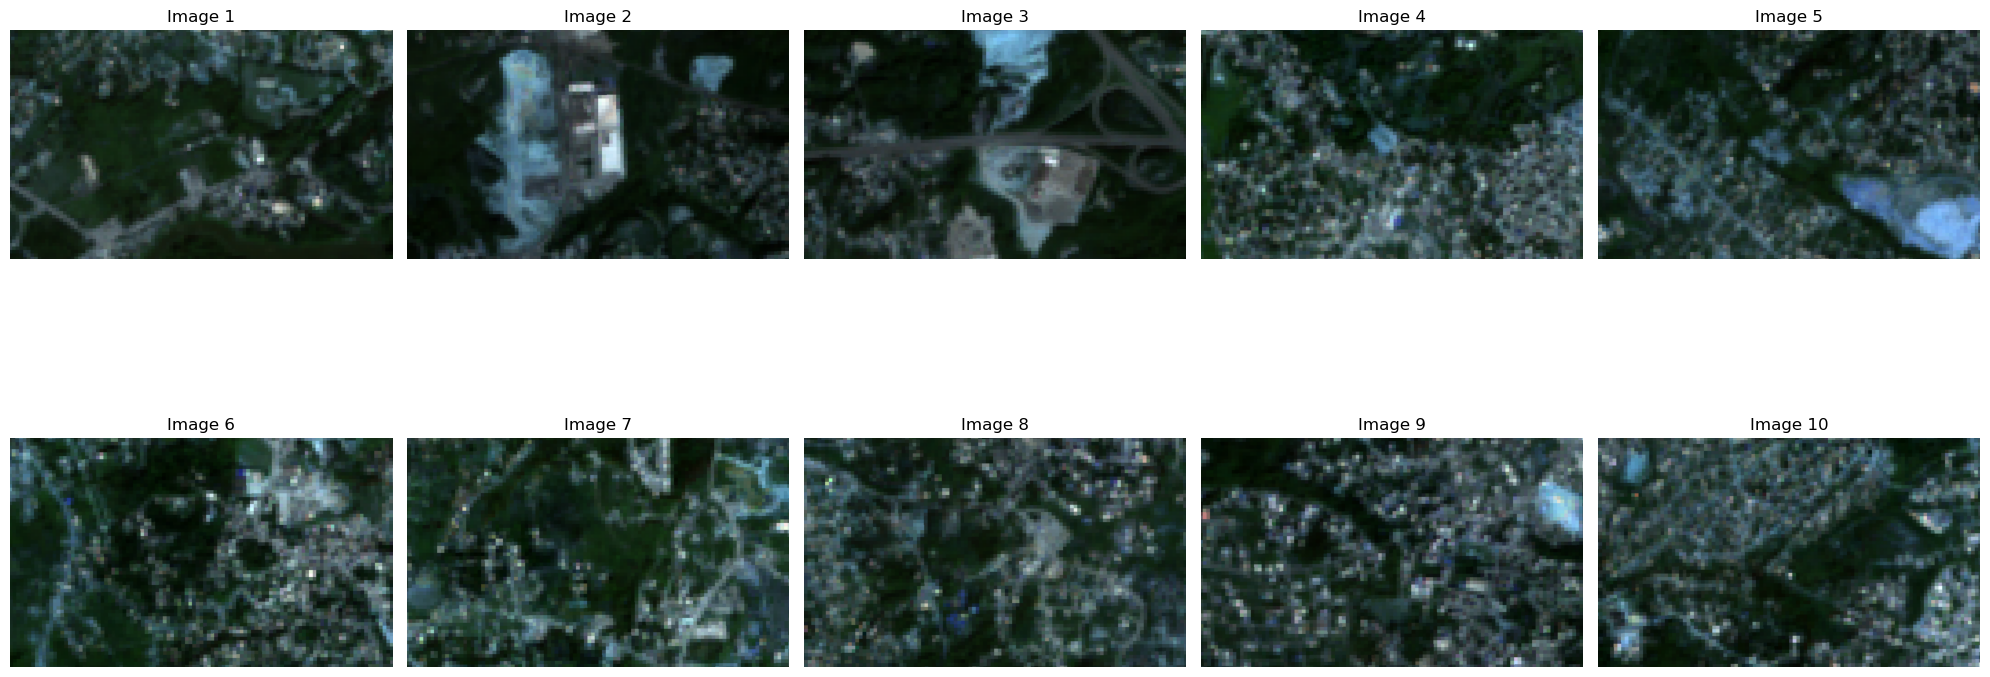

In [13]:
# Show the images in image_list_testing
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(image_list[i-1])
    ax.axis("off")
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [14]:
# Check if img_effnet7_features.csv exists
if not os.path.exists(os.path.join("output", "img_effnet7_features.csv")):
    df_effnet_features = fe.extract(effnet, effnet_p, image_list, (662, 1103, 3))
    df_effnet_features.to_csv(os.path.join("output", "img_effnet7_features.csv"), index=True)
else:
    df_effnet_features = pd.read_csv(os.path.join("output", "img_effnet7_features.csv"), index_col=0)


In [15]:
df_effnet_features.shape

(900, 2560)

In [16]:
df_effnet_features.head(10)

0         1         2         3         4         5         6  \
0  0.202694 -0.081792 -0.227756  0.155381 -0.066303  0.002430  0.035001   
1  0.037100 -0.020237 -0.213950  0.112765 -0.156207 -0.039857  0.077102   
2  0.109109 -0.172439 -0.231494  0.057703 -0.164295 -0.040664 -0.061876   
3  0.041409 -0.185916 -0.217001 -0.012261 -0.168160 -0.092132 -0.053870   
4  0.060620 -0.194082 -0.217579 -0.067940 -0.166668 -0.115366 -0.037999   
5 -0.016897 -0.185143 -0.202755 -0.084915 -0.157805 -0.124236 -0.010070   
6  0.045892 -0.204745 -0.218579 -0.090543 -0.154940 -0.114324 -0.000402   
7 -0.037340 -0.219596 -0.214401 -0.091312 -0.171417 -0.132528  0.020134   
8  0.008474 -0.160905 -0.210314 -0.055348 -0.158117 -0.086925 -0.023249   
9  0.225928 -0.212366 -0.231926 -0.015924 -0.147499  0.008213 -0.012783   

          7         8         9  ...      2550      2551      2552      2553  \
0  0.128959  0.131514 -0.164019  ...  0.102956 -0.033326 -0.206493  0.235746   
1  0.010710 -0.031621 -0.157502  ...  0.249663 -0.095952 -0.192630  0.116444   
2 -0.019940 -0.014259 -0.162000  ...  0.024788 -0.050463 -0.183824  0.251548   
3 -0.079329 -0.109836 -0.177992  ... -0.010581 -0.161669 -0.183999  0.187722   
4 -0.117710 -0.101637 -0.195789  ... -0.024119 -0.124708 -0.169687  0.267371   
5 -0.074056 -0.077459 -0.177790  ... -0.021175 -0.129078 -0.150748  0.119138   
6 -0.108396 -0.103337 -0.187470  ... -0.024018 -0.157432 -0.168516  0.215469   
7 -0.084107 -0.137452 -0.161415  ... -0.022609 -0.157213 -0.135124  0.128742   
8 -0.055427 -0.117473 -0.186271  ... -0.050555 -0.168642 -0.164257  0.223622   
9 -0.098941 -0.035582 -0.205686  ... -0.073883 -0.127068 -0.174310  0.250908   

       2554      2555      2556      2557      2558      2559  
0 -0.083914 -0.018846 -0.127156 -0.037394  0.006842 -0.018068  
1  0.015505 -0.070586 -0.194139 -0.112880 -0.052699  0.020254  
2 -0.035079 -0.157421 -0.171556 -0.035112 -0.070191 -0.162780  
3 -0.030637 -0.170584 -0.192873 -0.070221 -0.106276 -0.195337  
4 -0.026533 -0.185577 -0.178434 -0.091514 -0.116363 -0.211351  
5 -0.036412 -0.157899 -0.181190 -0.108804 -0.092638 -0.188304  
6 -0.011816 -0.177535 -0.167003 -0.084924 -0.112298 -0.204882  
7 -0.036155 -0.198045 -0.180229 -0.074238 -0.103988 -0.192159  
8 -0.041020 -0.177900 -0.190913 -0.024267 -0.087423 -0.186487  
9 -0.046442 -0.188797 -0.186706 -0.009076 -0.054113 -0.171229  

[10 rows x 2560 columns]

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [18]:
scaler = StandardScaler()
df_effnet_features_pca = scaler.fit_transform(df_effnet_features)

In [19]:
# Use PCA to reduce the dimensionality of the features
pca = PCA(random_state=SEED)
pca.fit(df_effnet_features_pca)

PCA(random_state=2024)

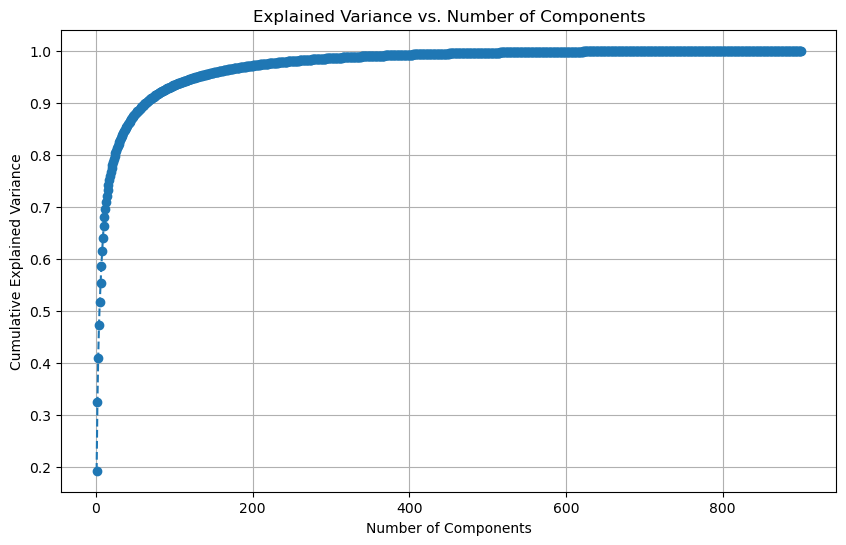

In [20]:
# Plot the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [21]:
# For example, if you want to retain 95% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f'Number of components to retain 95% variance: {n_components}')

Number of components to retain 95% variance: 130


In [22]:
pca = PCA(n_components=2, random_state=SEED)
pca.fit(df_effnet_features_pca)

PCA(n_components=2, random_state=2024)

In [23]:
# Transform the features
df_effnet_features_pca = pd.DataFrame(pca.transform(df_effnet_features_pca), index=df_effnet_features.index)

In [24]:
# Add the image_list items to the DataFrame (line them up)
df_effnet_features_pca["image"] = image_list

In [25]:
# Get the color average of each image
df_effnet_features_pca["color_avg"] = df_effnet_features_pca["image"].apply(lambda x: np.mean(x, axis=(0, 1)))
# Convert the RGB lists to a format suitable for Matplotlib
df_effnet_features_pca['color_avg'] = df_effnet_features_pca['color_avg'].apply(lambda x: [c/255 for c in x])


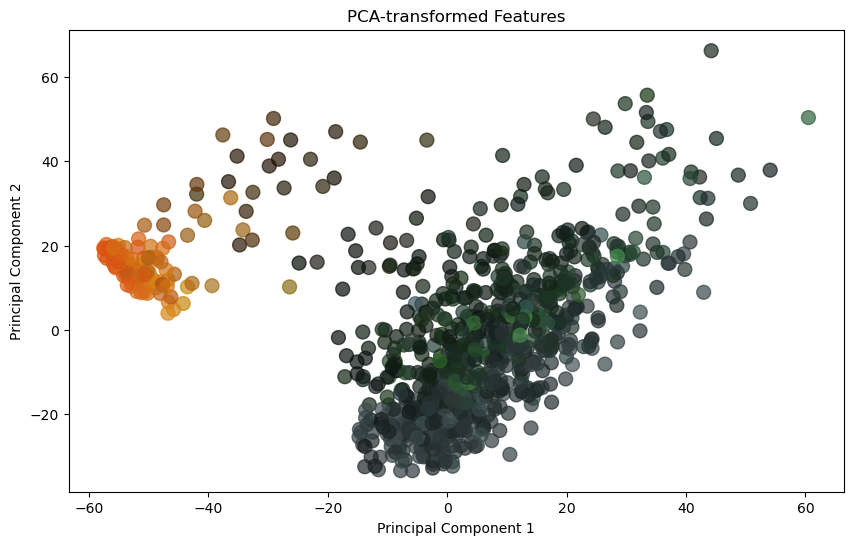

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(
    x=df_effnet_features_pca[0], 
    y=df_effnet_features_pca[1], 
    c=df_effnet_features_pca['color_avg'].tolist(), 
    s=100, 
    edgecolor=None, 
    alpha=0.7
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA-transformed Features")
plt.show()


In [27]:
effnet_features_pca_130 = scaler.fit_transform(df_effnet_features)

In [28]:
pca = PCA(n_components=130, random_state=SEED)
pca.fit(effnet_features_pca_130)
effnet_features_pca_130 = pd.DataFrame(pca.transform(effnet_features_pca_130), index=df_effnet_features.index)

In [29]:
# Cluster the features using KMeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=50, random_state=SEED)
effnet_features_pca_130["cluster"] = kmeans.fit_predict(effnet_features_pca_130)

In [65]:
effnet_features_pca_130_copy = scaler.fit_transform(df_effnet_features)
pca = PCA(n_components=130, random_state=SEED)
pca.fit(effnet_features_pca_130_copy)
effnet_features_pca_130_copy = pd.DataFrame(pca.transform(effnet_features_pca_130_copy), index=df_effnet_features.index)

In [67]:
# Calculate silhouette score
from sklearn.metrics import silhouette_score

sil = []
kmax = 100

for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=SEED).fit(effnet_features_pca_130_copy)
    labels = kmeans.labels_
    sil.append(silhouette_score(effnet_features_pca_130_copy, labels, metric='euclidean'))

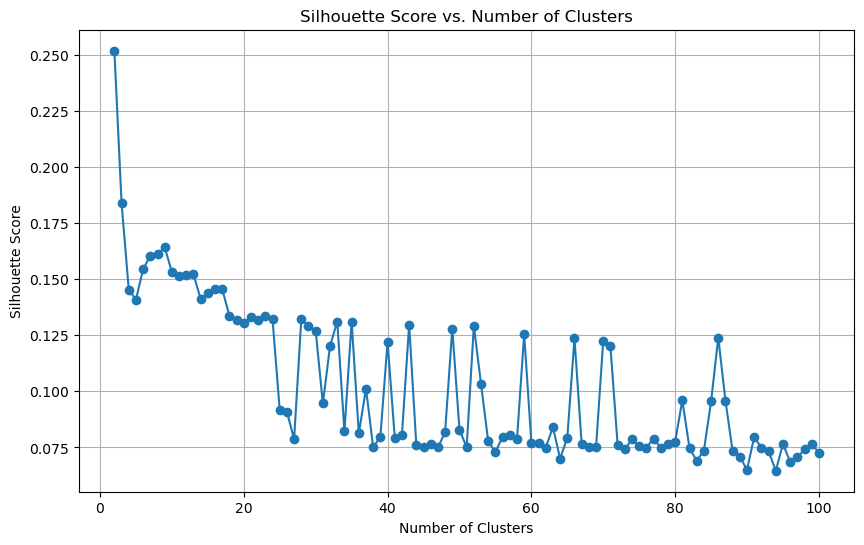

In [68]:
# Plot silhouette score
plt.figure(figsize=(10, 6))
plt.plot(range(2, kmax+1), sil, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

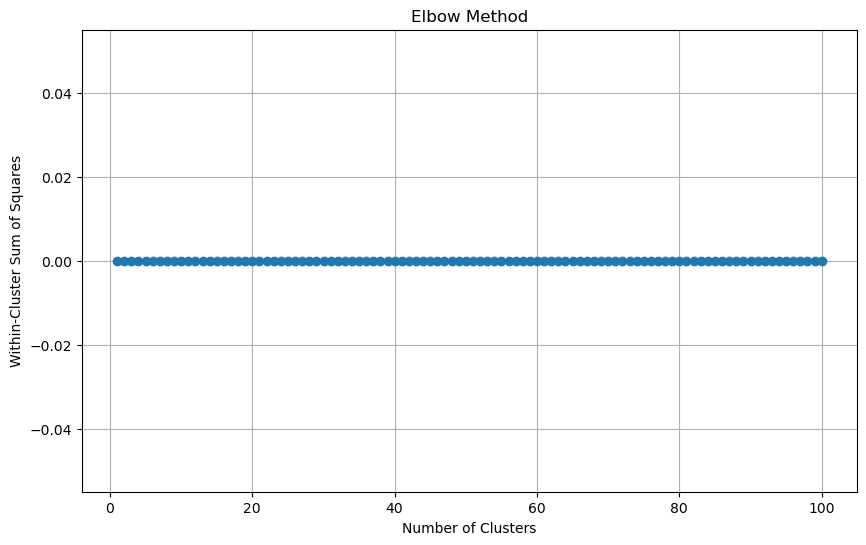

In [74]:
# Create elbow plot
from sklearn.cluster import KMeans

def calculate_WSS(points, kmax):
    if len(points) == 0:
        return []
    
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters=k, random_state=SEED).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # Calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            
            try:
                curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
            except:
                pass

        sse.append(curr_sse)
    return sse

wss = calculate_WSS(effnet_features_pca_130_copy, 100)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), wss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [30]:
effnet_features_pca_130

0          1          2          3          4         5  \
0    24.365006  18.205112  -2.842018 -10.919543  -7.817118 -3.393255   
1    34.466219  20.370707  -9.559679 -17.328113  -8.668020  9.375979   
2    12.057910  -9.799786  -4.530894   9.734322  -2.389897 -1.038623   
3    -1.321842 -21.274038 -21.195892 -11.777363 -11.560328  4.941210   
4    -2.368635 -25.444682 -12.894121  -5.547478 -14.229285  3.172904   
..         ...        ...        ...        ...        ...       ...   
895  12.024054  -6.981150 -21.853232  -7.739041 -23.055114  0.863805   
896  11.048117   5.037850 -19.476342  -2.808255  -6.980486  1.696833   
897  17.098596  11.099240 -11.256549  -0.399563  10.011592 -6.378980   
898  16.523991  16.640259 -14.430239  -3.006154   6.630226 -2.195071   
899  17.503616  -4.195217 -25.691704 -12.122619 -11.637449 -2.123080   

             6         7          8          9  ...       121       122  \
0   -14.525907 -2.030793   3.398357 -15.137730  ...  1.797449  0.017894   
1    13.981048  3.031735   6.932323 -17.025152  ...  1.336911 -2.370507   
2    -7.772045 -7.809718   0.151876  -6.229344  ...  0.620903  0.691077   
3    12.198302 -5.684229  -0.318697   3.971593  ...  0.446867  0.343112   
4     7.695424 -7.033724  -2.092194  -1.591700  ...  0.074940  0.013735   
..         ...       ...        ...        ...  ...       ...       ...   
895   0.174928 -1.692018   6.724430  -3.376479  ...  1.211537 -1.250392   
896   3.907369  5.694946   5.473121  -8.737822  ... -0.553170 -0.391951   
897   0.774232  6.076487  -9.094864  12.497882  ...  1.918945 -0.997252   
898  -0.420246  8.106885 -11.759373   7.571478  ...  1.846432 -0.970249   
899   4.726755 -6.695435   7.181269   1.849244  ...  1.179370 -0.074201   

          123       124       125       126       127       128       129  \
0    0.701555 -2.500927  2.121857  1.813541  0.352522 -1.071764  0.054000   
1   -0.880670  1.709991  0.239842 -0.324313 -1.904057  1.685927 -0.279852   
2   -0.090492 -0.152617 -0.635927  0.860427  1.479596  0.104604 -0.357040   
3    0.703561 -0.082691  1.414030  0.170405 -0.073973 -0.588222  0.845539   
4    0.123127  0.174361  0.610445  0.266928  0.151636 -0.375129  0.326921   
..        ...       ...       ...       ...       ...       ...       ...   
895  0.731412  1.597628  2.102851 -0.145765 -0.326784 -1.506645 -0.365097   
896 -1.304139  0.936094 -1.251243  1.799360  0.351742  0.111573  1.870459   
897 -0.691127  0.844880 -0.729062  1.469086  2.737154 -0.311762  0.474620   
898 -0.606339 -1.252985  0.291322  0.457449 -0.731890 -1.575731  0.154211   
899  0.374467  0.933482 -0.167162 -0.637910 -0.335894  0.622654  0.193462   

     cluster  
0         29  
1         11  
2         42  
3          1  
4          1  
..       ...  
895        6  
896        6  
897       15  
898       15  
899        6  

[900 rows x 131 columns]

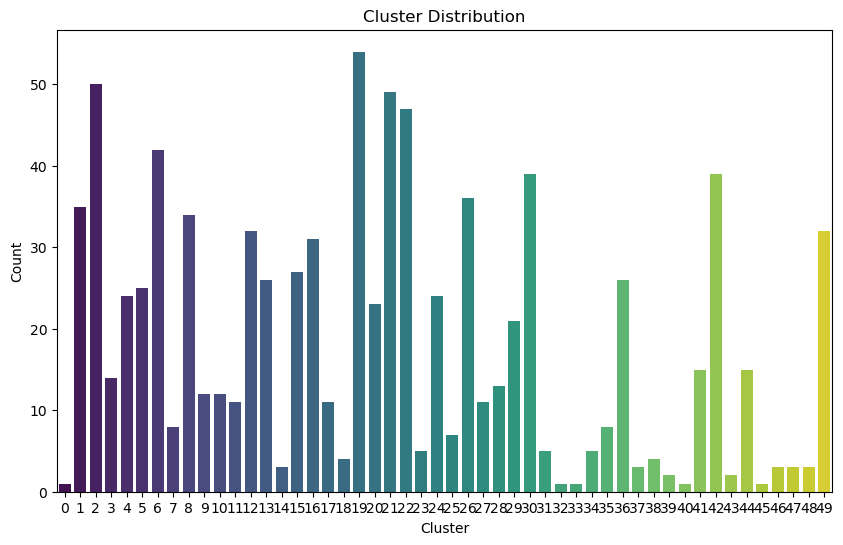

In [31]:
# What is the distribution of clusters?
cluster_counts = effnet_features_pca_130["cluster"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cluster Distribution")
plt.show()

In [32]:
effnet_features_pca_130["image"] = image_list

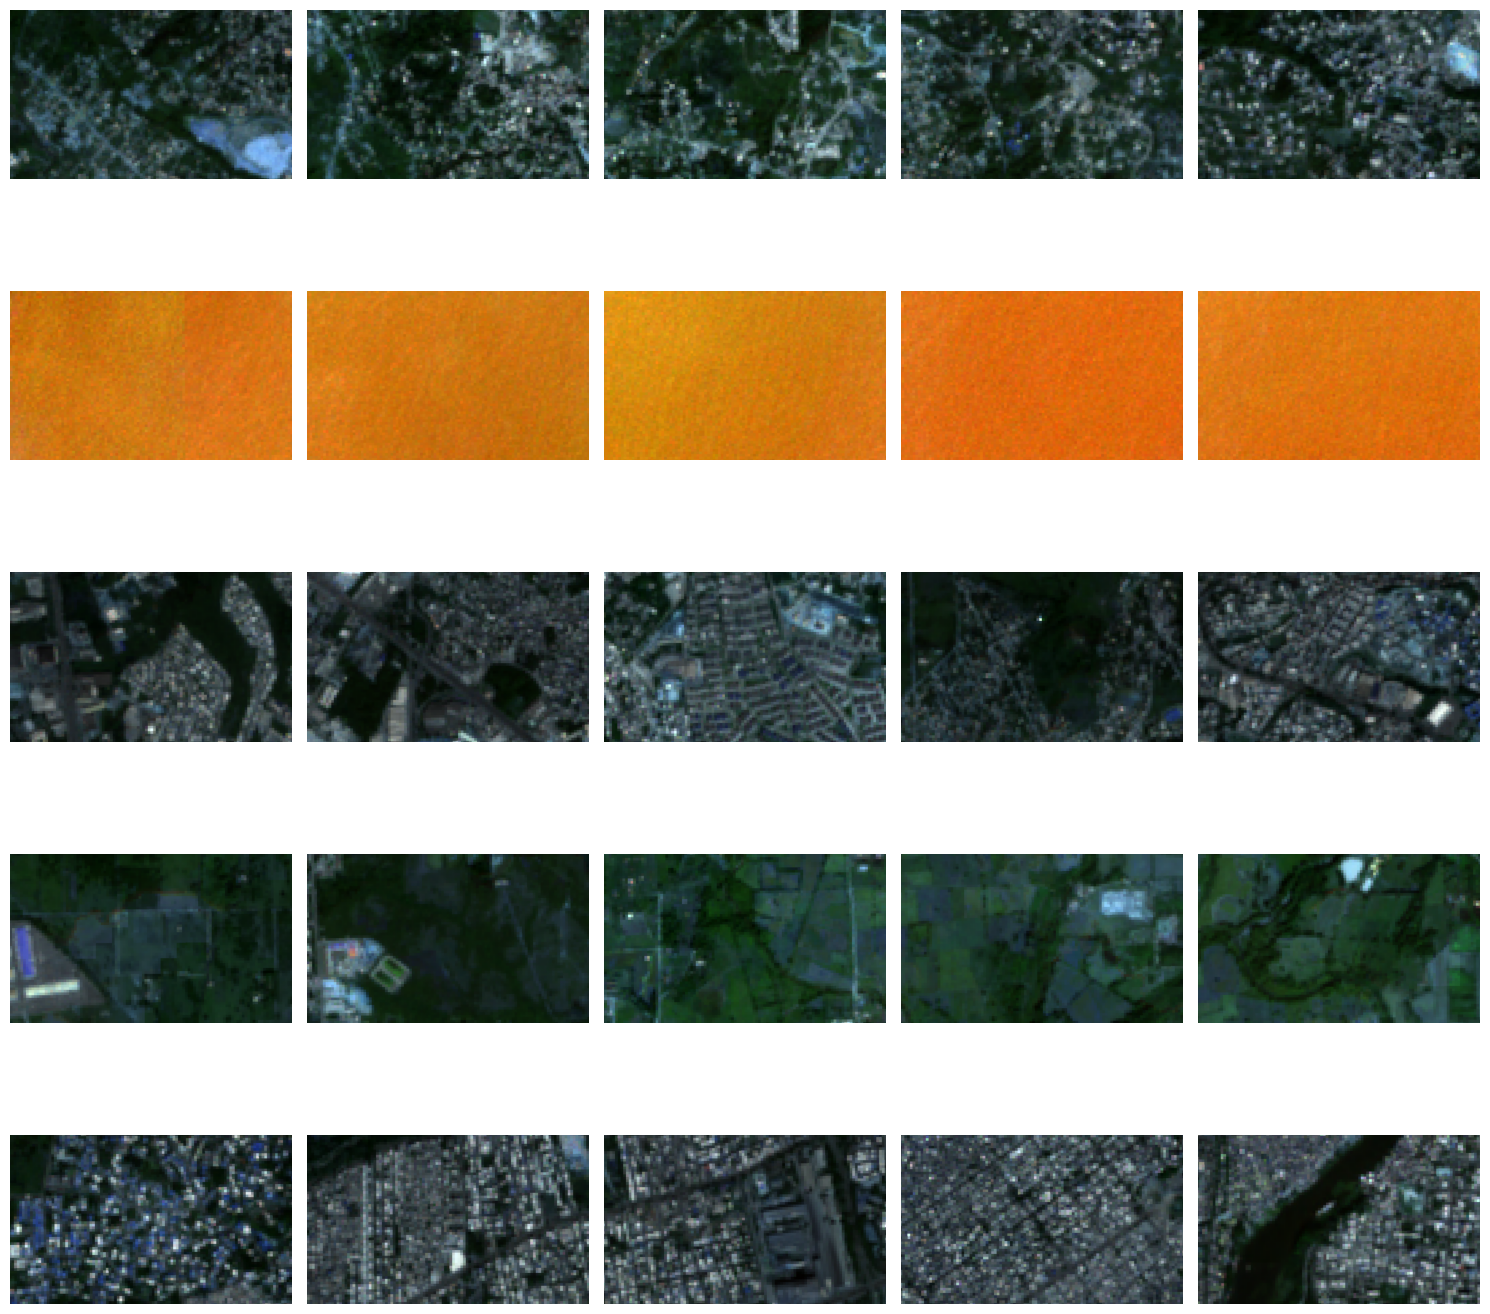

In [33]:

# Filter 5 images for each cluster from 1 to 5
start_cluster = 1
end_cluster = 5
num_images_per_cluster = 5

# Create a plot with 5x5 subplots
fig, axes = plt.subplots(end_cluster - start_cluster + 1, num_images_per_cluster, figsize=(15, 15))

for cluster in range(start_cluster, end_cluster + 1):
    cluster_images = effnet_features_pca_130[effnet_features_pca_130['cluster'] == cluster]['image'].head(num_images_per_cluster)
    for i, img in enumerate(cluster_images):
        axes[cluster - start_cluster, i].imshow(img)
        axes[cluster - start_cluster, i].axis('off')  # Hide axes for a cleaner look

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

In [34]:
# Load in the raster data as rasterio objects and add them to the dataframe

for i, img_path in enumerate(os.listdir("temporary")):
    temp_raster = rasterio.open(os.path.join("temporary", img_path))
    effnet_features_pca_130.loc[i, "raster"] = temp_raster
    effnet_features_pca_130.loc[i, "raster_path"] = os.path.join("temporary", img_path)


In [35]:
# Add a new column titled geometry_i to the dataframe, it is the digits just before the ".tif" in the raster_path
effnet_features_pca_130["geometry_i"] = effnet_features_pca_130["raster_path"].str.extract(r"(\d+)\.tif")

In [36]:
# Create copy of effnet_features_pca_130 with only the cluster and geometry_i columns
cluster_df = effnet_features_pca_130[["cluster", "geometry_i"]]

In [37]:
subgeometries = split_geometry(geometry_sd, num_parts=30)

# Export and download each subregion
for i, subgeometry in enumerate(subgeometries):
    # Print the coordinates of the subgeometry
    # Add the subgeometry to the cluster_df based on the geometry_i and i
    cluster_df.loc[cluster_df["geometry_i"] == str(i), "geometry"] = subgeometry

In [38]:
# Convert the cluster_df to a GeoDataFrame
cluster_gdf = gpd.GeoDataFrame(cluster_df, geometry="geometry")

# Add crs to the GeoDataFrame
cluster_gdf.crs = "EPSG:4326"

In [39]:
import matplotlib.colors as mcolors

In [40]:
# Plot the clusters on the map
m = folium.Map(location=[18.483402, -69.929611], zoom_start=12)

color_type = {
    "land": "darkgreen",
    "urban": "yellow",
    "water": "blue",
    "coast": "lightblue",
    "mix": "lightgreen"
}

# Define colors for each cluster
colors = {
    '0': color_type["land"],
    '1': color_type["mix"], #
    '2': color_type["water"], #
    '3': color_type["land"],
    '4': color_type["land"],
    '5': color_type["urban"], #
    '6': color_type["mix"], #
    '7': color_type["land"],
    '8': color_type["urban"], #
    '9': color_type["urban"], #
    '10': color_type["coast"],
    '11': color_type["land"],
    '12': color_type["land"],
    '13': color_type["urban"], #
    '14': color_type["urban"], #
    '15': color_type["land"],
    '16': color_type["land"],
    '17': color_type["water"], #
    '18': color_type["urban"],
    '19': color_type["urban"], #
    '20': color_type["urban"], #
    '21': color_type["water"], #
    '22': color_type["mix"], #
    '23': color_type["mix"], #
    '24': color_type["land"],
    '25': color_type["land"],
    '26': color_type["urban"], #
    '27': color_type["land"],
    '28': color_type["land"],
    '29': color_type["land"],
    '30': color_type["land"],
    '31': color_type["land"],
    '32': color_type["land"],
    '33': color_type["land"],
    '34': color_type["land"],
    '35': color_type["urban"], #
    '36': color_type["urban"], #
    '37': color_type["land"],
    '38': color_type["land"],
    '39': color_type["land"],
    '40': color_type["land"],
    '41': color_type["land"],
    '42': color_type["mix"], #
    '43': color_type["land"],
    '44': color_type["urban"], #
    '45': color_type["land"],
    '46': color_type["land"],
    '47': color_type["land"],
    '48': color_type["land"],
    '49': color_type["mix"], #
    '50': color_type["land"],
}


for i, row in cluster_gdf.iterrows():
    cluster_number = row['cluster']  # Get the cluster number outside the lambda function

    folium.GeoJson(
        row["geometry"],
        popup=f"Cluster {cluster_number}",
        name=f"Cluster {cluster_number}",
        style_function=lambda x, cluster=cluster_number: {  # Pass cluster number as parameter
            'fillColor': colors[str(cluster)],
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.5
        },
    ).add_to(m)



m

In [41]:
# Create a new Geodataframe where all rows with the same cluster are join together
cluster_gdf_merged = cluster_gdf.dissolve(by="cluster")

In [48]:
# Load in the Santo Domingo Precarious Settlements dataset
precario_path = os.path.join("data", "SantoDomingo_PC.zip")
precario_gdf = gpd.read_file(precario_path)

In [59]:
visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

m = geemap.Map()
m.set_center(-69.929611, 18.483402, 12)
m.add_layer(sd_cutout, visualization, 'RGB')

# Generate a colormap with 50 distinct colors
num_clusters = 50
cmap = plt.get_cmap('tab20')  # You can choose other colormaps like 'tab20', 'tab20c', etc.
colors = cmap(np.linspace(0, 1, num_clusters))

# Create a dictionary mapping each cluster number to a color
colormap = {i + 1: mcolors.rgb2hex(colors[i]) for i in range(num_clusters)}

m.add_gdf(cluster_gdf_merged, layer_name='Clusters', fill_colors=list(colormap.values()), style={'fillOpacity': 0.75, 'opacity': 0},
          hover_style={'fillOpacity': 0.25, 'opacity': 1})

m.add_gdf(precario_gdf, layer_name='Precarious Settlements', fill_colors='red', style={'fillOpacity': 0.75, 'opacity': 0})

m

Map(center=[18.483402, -69.929611], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

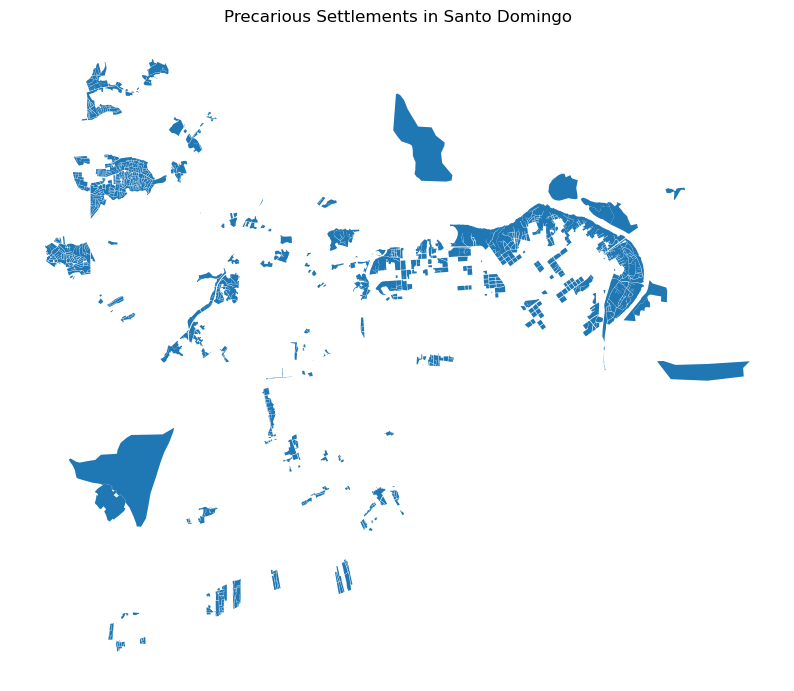

In [49]:
# Plot the Precarious Settlements data using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
precario_gdf.plot(ax=ax)
plt.title("Precarious Settlements in Santo Domingo")
plt.axis("off")
plt.show()